## Collaborative Filtering 
Is where it gets interesting.  The behaviours between users and items; in this case users and patterns are assesed and we can get recommendations like:  Oth 

* Serendipty - help find new patterns wouldn't have looked at before

* Disadvantage - cold start problem. A new pattern or user added to the 

User-User, Item- Item...
"I’m going to go with item-item because it’s generally been found to be more effective, but also because it can immediately make fairly good recommendations to new users (assuming you already have other user reviews in place)."
https://medium.com/@jmcneilkeller/item-item-recommendation-with-surprise-4bf365355d96


There are two types of Collaborative Filtering.
#### Memory Based
In this case I've used K Nearest Neighbours to find item-item similarity. 
(clustering knn model based 

- Disadvantages:  Doesn't perform well with sparse data. 

#### Model Based
Finds latent features through matrix factorization. 

In this case I've used trucated SVD.  Trucated; because when I attempted to perform full SVD on the dataset it was too much for 39 gb RAM on google colab to handle.  SVD is a ...

Implicit Alternating Mean Squares - 

Also tried this out on my own profile for find patterns that match . 

More can be read here:
https://en.m.wikipedia.org/wiki/Collaborative_filtering

next steps:
Behaviour sequence transformer
https://keras.io/examples/structured_data/movielens_recommendations_transformers/

Note about accuacy - over fitting 
# not going to tune as prone to overfitting https://towardsdatascience.com/svd-where-model-tuning-goes-wrong-61c269402919
https://towardsdatascience.com/building-a-collaborative-filtering-recommender-system-with-clickstream-data-dffc86c8c65

In [116]:
# import libraries
import pandas as pd
import numpy as np

# KNN
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

# Truncated SVD
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# implicit
import implicit
import scipy.sparse as sparse

In [117]:
# load data
# This is to display metadata of the recommended patterns
pattern_details = pd.read_csv('data/consolidated_patterns.csv', low_memory=False)

# This is the user/ project/ pattern dataframe, after eliminating any patterns or users below a certain project number threshold
df = pd.read_csv('data/less_sparse_users_patterns.csv', low_memory=False)

In [118]:
pattern_details.shape, df.shape

((188158, 24), (3250978, 5))

In [119]:
df.head()

,user_id,pattern_ids,date_completed,project_id,has_knit
0,5153610,88,2021/11/19,29203938,1
1,511279,88,2021/11/03,29103788,1
2,3146767,88,2021/03/20,27956252,1
3,21965,88,2021/01/30,27619530,1
4,55722,88,2020/12/31,27370585,1


In [120]:
#  merge with df to get metadata for each pattern 
metadata = pattern_details[pattern_details['pattern_id'].isin(df.pattern_ids.values)]
print(metadata.shape)
metadata.head(2)

(2963, 24)


,pattern_id,name,name_permalink,favorites_count,projects_count,difficulty_average,difficulty_count,rating_average,queued_projects_count,rating_count,...,pattern_attributes,yardage_max,yardage,generally_available,gauge,gauge_divisor,free,downloadable,categories,yarn_weight_description
0,88,Calorimetry,calorimetry,29838,19426,1.816424,7294.0,4.225295,7895,6618.0,...,"['unisex', 'teen', 'adult', 'fitted', 'reversi...",NaN,93.0,2006/12/01 00:00:00 -0500,20.0,4.0,True,True,"['headband', 'headwear', 'accessories']",Aran (8 wpi)
1,3156,Basic Ribbed Socks,basic-ribbed-socks,17795,10987,2.435581,2670.0,4.455242,3519,2480.0,...,"['unisex', 'adult', 'top-cuff-down', 'heel-fla...",NaN,370.0,2006/04/01 00:00:00 -0500,32.0,4.0,True,True,"['mid-calf', 'socks', 'feet-legs', 'accessories']",Fingering (14 wpi)


#### Utility Matrix
Create a utility matrix (pattern_ids as indices and columns are the user_ids. Cells filled with 1's where the user knit the pattern.

In [121]:
user_knit = df.copy()
user_knit = user_knit.drop_duplicates(['user_id', 'pattern_ids'])  

user_knit_pivot = user_knit.pivot(index='pattern_ids', columns='user_id', values='has_knit').fillna(0)
user_knit_matrix = csr_matrix(user_knit_pivot.values)
print(user_knit_pivot.shape, user_knit_matrix.shape)
user_knit_pivot.head(3)

(2961, 338751) (2961, 338751)


user_id,1,3,4,5,6,7,12,14,15,16,...,10459616,10460934,10461299,10464282,10465055,10468050,10469329,10478891,10483259,10488620
pattern_ids,,,,,,,,,,,,,,,,,,,,,
10,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Memory Based Filter

**
memory based
2 methods pearson correlation 
or cosine similartity
Nearest neighbours, 
disadvantages:as matrices become sparse, performance decreases - explain metrics obtained

### k-Nearest Neighbours (kNN)

An algorithm to find clusters of similar knitting patterns based on similar users' knitted choices. (Or similar users.)

Apply sklearn kNN aglorithm:

In [122]:
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')  # default default=’minkowski’ (real value space) - try “jaccard” (boolean vector space)
model_knn.fit(user_knit_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

Choose pattern for recommendation:

In [192]:
chosen_name_permalink = 'eunice'
query_pattern_id = get_pattern_id_from_name(chosen_name_permalink)
distances, indices = model_knn.kneighbors(user_knit_pivot.loc[query_pattern_id,:].values.reshape(1, -1), n_neighbors = 10)

In [193]:
# TODO turn into one function! pattern id to name! 

def get_index_from_pattern_id(pattern_id):
    return metadata[metadata.pattern_id == pattern_id].index[0]

# pattern_id = int(user_knit_pivot.index[query_index])
pattern_index = get_index_from_pattern_id(pattern_id)

def get_pattern_name_from_index(pattern_index):
    return metadata[metadata.index == pattern_index]["name_permalink"].values[0]

def get_pattern_name_from_pattern_id(pattern_id):
    name = metadata[metadata.pattern_id == pattern_id]['name_permalink']
    return name[name.keys()[0]]

def get_index_from_pattern_id(pattern_id):
    return metadata[metadata.pattern_id == pattern_id].index[0]

def get_pattern_id_from_name(name_permalink):
    pattern_id = metadata[metadata.name_permalink == name_permalink]['pattern_id']
    return pattern_id[pattern_id.keys()[0]]

In [195]:
# give recomendations for the pattern selected
pattern_ids=[]
pattern_indices = []
pattern_name= []
for i in range(0, len(distances.flatten())):
    if i == 0:
  
            print('Recommendations for {0}:\n'.format(get_pattern_name_from_index(get_index_from_pattern_id(int(query_pattern_id)))))

    else:
        pattern_id = int(user_knit_pivot.index[indices.flatten()[i]])
        pattern_metadata_index = get_index_from_pattern_id(pattern_id)
        pattern_name = get_pattern_name_from_index(pattern_metadata_index)
        pattern_indices.append(pattern_metadata_index)
        print('{0}: {1} {2}, with distance of: {3}'
                .format(i, pattern_id, pattern_name, distances.flatten()[i]))
    
closest_df_knn = metadata.loc[pattern_indices]
closest_df_knn 

Recommendations for eunice:

1: 112294 glynis, with distance of: 0.6824124949532429
2: 112324 sunshine-11, with distance of: 0.6897632169718348
3: 112781 vilai, with distance of: 0.7256656559768451
4: 112785 wanida, with distance of: 0.7562502343516415
5: 112783 angee, with distance of: 0.7671536593800528
6: 113101 cauchy, with distance of: 0.8096685349681674
7: 113124 kai-mei, with distance of: 0.8214977447793189
8: 113105 rick, with distance of: 0.8295890368846288
9: 37539 marilinda, with distance of: 0.8328826155887887


,pattern_id,name,name_permalink,favorites_count,projects_count,difficulty_average,difficulty_count,rating_average,queued_projects_count,rating_count,...,pattern_attributes,yardage_max,yardage,generally_available,gauge,gauge_divisor,free,downloadable,categories,yarn_weight_description
5355,112294,Glynis,glynis,608,926,3.936264,455.0,4.065574,346,427.0,...,"['adult', 'top-cuff-down', 'heel-flap', 'lace'...",NaN,350.0,2009/04/01 00:00:00 -0400,30.0,4.0,False,False,"['mid-calf', 'socks', 'feet-legs', 'accessories']",Fingering (14 wpi)
2173,112324,Sunshine,sunshine-11,1134,1266,3.276973,621.0,4.356303,489,595.0,...,"['female', 'teen', 'adult', 'top-cuff-down', '...",NaN,382.0,2009/04/01 00:00:00 -0400,30.0,4.0,False,False,"['mid-calf', 'socks', 'feet-legs', 'accessories']",Fingering (14 wpi)
122679,112781,Vilai,vilai,798,896,5.362256,461.0,4.585648,448,432.0,...,"['female', 'top-cuff-down', 'heel-flap', 'cabl...",430.0,360.0,2009/04/01 00:00:00 -0400,32.0,4.0,False,False,"['mid-calf', 'socks', 'feet-legs', 'accessories']",Fingering (14 wpi)
3695,112785,Wanida,wanida,925,1336,3.406919,607.0,4.377966,501,590.0,...,"['adult', 'top-cuff-down', 'heel-flap', 'lace'...",NaN,350.0,2009/04/01 00:00:00 -0400,32.0,4.0,False,False,"['mid-calf', 'socks', 'feet-legs', 'accessories']",Fingering (14 wpi)
1750,112783,Angee,angee,899,1652,3.284337,830.0,4.473618,476,796.0,...,"['unisex', 'teen', 'adult', 'negative-ease', '...",578.0,289.0,2009/04/01 00:00:00 -0400,32.0,4.0,False,False,"['mid-calf', 'socks', 'feet-legs', 'accessories']",Fingering (14 wpi)
2747,113101,Cauchy,cauchy,617,1023,2.436214,486.0,4.326039,347,457.0,...,"['unisex', 'adult', 'top-cuff-down', 'heel-fla...",NaN,378.0,2009/04/01 00:00:00 -0400,32.0,4.0,False,False,"['mid-calf', 'socks', 'feet-legs', 'accessories']",Fingering (14 wpi)
109596,113124,Kai-Mei,kai-mei,3475,3057,3.759135,1341.0,4.499619,1161,1313.0,...,"['female', 'adult', 'negative-ease', 'top-cuff...",NaN,450.0,2009/04/01 00:00:00 -0400,33.0,4.0,False,False,"['mid-calf', 'socks', 'feet-legs', 'accessories']",Fingering (14 wpi)
5358,113105,Rick,rick,946,1003,4.208633,417.0,4.251870,549,401.0,...,"['male', 'top-cuff-down', 'heel-flap', 'ribbed...",450.0,360.0,2009/04/01 00:00:00 -0400,32.0,4.0,False,False,"['mid-calf', 'socks', 'feet-legs', 'accessories']",Fingering (14 wpi)
122593,37539,Marilinda,marilinda,1381,721,4.038339,313.0,4.516129,592,310.0,...,"['female', 'teen', 'adult', 'top-cuff-down', '...",450.0,400.0,2007/06/01 00:00:00 -0400,32.0,4.0,False,True,"['mid-calf', 'socks', 'feet-legs', 'accessories']",Light Fingering


## Matrix factorization 

model based
SVD - dimensionality reduction 
better with sparsenes
### a) Truncated SVD (explain all of the methods)

In [ ]:
# user_knit = df
# user_knit = user_knit.drop_duplicates(['user_id', 'pattern_ids'])
# user_knit_pivot = user_knit.pivot(index='pattern_ids', columns='user_id', values='has_knit').fillna(0)
# user_knit_matrix = csr_matrix(user_knit_pivot.values)
# user_knit_pivot.shape, user_knit_matrix.shape

In [11]:
# Set up matrix for decomposition
X = user_knit_pivot.values
X

array([[1., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [12]:
# fit model 
svd = TruncatedSVD(n_components=100, random_state =88)
matrix = svd.fit_transform(X)
matrix.shape

(2961, 100)

In [102]:
# To determine best number (have increased from 10 iteratively to 1000 (explained variab
# should be above 0.9, but seems that each component only contributes a little to the explained variance. 

explained_variance_ratios = svd.explained_variance_ratio_
explained_variance_ratios_sum = svd.explained_variance_ratio_.sum()
singular_values = svd.singular_values_
print(explained_variance_ratios_sum )

0.2281216043470396


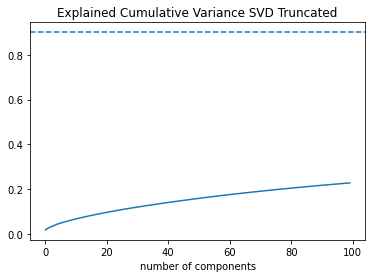

In [115]:
#Plot Explained Variabce

cumulative_exp_variance = np.cumsum(explained_variance_ratios)

fig, ax = plt.subplots()
plt.title("Explained Cumulative Variance SVD Truncated")
ax.axhline(y=0.9, linestyle='--')
plt.xlabel("Number of Components")
ax.plot(cumulative_exp_variance);



In [16]:
# calculate pearson R correlation 
corr = np.corrcoef(matrix)
corr.shape

(2961, 2961)

In [17]:
# get pattern id's into a list to be able to access indicies
pattern_ids = user_knit_pivot.index
pattern_ids_list = list(pattern_ids)

In [18]:
# user_knit_pivot.index

In [54]:
# Find recommendations for a particular pattern:

88

In [19]:
# choose a pattern
name_permalink = 'featherweight-cardigan'
# Do try except!!! spit out something ********************

# get pattern_id in order to: get index from utility matrix
chosen_pattern_id = metadata['pattern_id'][metadata['name_permalink'] ==name_permalink].values[0]

# get index from utility matrix
chosen_patten_index = pattern_ids_list.index(chosen_pattern_id) #24

# get correlations from utility matrix
correlations = corr[pattern_ids_list.index(chosen_pattern_id)]#[0.51884817, 0.62498835, 0.32851777, .

# To sort patterns
zipped =zip(pattern_ids_list,correlations)
sorted_similar_patterns = sorted(zipped, key = lambda x: x[1], reverse=True)


# print("final list - ", str(res))

In [99]:
closest_indices = sorted_similar_patterns[:20]

pattern_ids = []
ordered_indices = []
for i in range(len(closest_indices)):
    if i == 0:
        print('Recommendations for {0} :\n'.format(get_pattern_name_from_pattern_id(closest_indices[i][0])))
    pattern_ids.append(closest_indices[i][0])
    ordered_indices.append(get_index_from_pattern_id(closest_indices[i][0]))
#     print(f'{get_pattern_name_from_pattern_id(closest_indices[i][0])} - {closest_indices[i][1]}')
    print('{0}: {1} {2}, with distance of: {3}'
                .format(i, closest_indices[i][0], get_pattern_name_from_pattern_id(closest_indices[i][0]), closest_indices[i][1]))

closest_df = metadata.loc[ordered_indices]
closest_df 


Recommendations for featherweight-cardigan :

0: 118491 featherweight-cardigan, with distance of: 1.0
1: 141029 lightweight-pullover, with distance of: 0.8582173507111434
2: 178174 adrift, with distance of: 0.8403030216824354
3: 205319 folded, with distance of: 0.8373253855593416
4: 177976 austin-hoodie, with distance of: 0.8358979563266019
5: 241118 calligraphy-cardigan, with distance of: 0.8326193448698954
6: 199730 harvest-moon-6, with distance of: 0.8291778548982994
7: 227449 irish-coffee, with distance of: 0.827266069097009
8: 211069 atelier, with distance of: 0.824860030487721
9: 265972 rocky-coast-cardigan, with distance of: 0.824185388690651
10: 175172 wispy-cardi, with distance of: 0.8225920808872803
11: 177479 acer-cardigan, with distance of: 0.8146958481239559
12: 149447 peasy, with distance of: 0.8054649806519019
13: 112344 buttercup-6, with distance of: 0.8046666171790819
14: 185454 goodale, with distance of: 0.8045884383112746
15: 159645 snowbird-2, with distance of: 0.80

,pattern_id,name,name_permalink,favorites_count,projects_count,difficulty_average,difficulty_count,rating_average,queued_projects_count,rating_count,...,pattern_attributes,yardage_max,yardage,generally_available,gauge,gauge_divisor,free,downloadable,categories,yarn_weight_description
12,118491,Featherweight Cardigan,featherweight-cardigan,46676,10136,2.456478,3010.0,4.453315,9647,2881.0,...,"['female', 'adult', 'petite', 'plus', 'fitted'...",2200.0,800.0,2009/04/01 00:00:00 -0400,24.0,4.0,False,True,"['cardigan', 'sweater', 'clothing']",Light Fingering
84258,141029,Lightweight Pullover,lightweight-pullover,10375,825,2.302083,288.0,4.647887,2119,284.0,...,"['female', 'adult', 'petite', 'plus', 'fitted'...",2353.0,1448.0,2009/09/01 00:00:00 -0400,24.0,4.0,False,True,"['pullover', 'sweater', 'clothing']",Sport (12 wpi)
10559,178174,Adrift,adrift,8933,614,2.458716,218.0,4.354369,1733,206.0,...,"['female', 'adult', '3-4-sleeve', 'cap-sleeve'...",2350.0,940.0,2010/05/01 00:00:00 -0400,25.0,NaN,False,True,"['cardigan', 'sweater', 'clothing']",Lace
2818,205319,Folded,folded,20013,1233,2.979499,439.0,4.453704,3892,432.0,...,"['waist', 'pleated', 'one-piece', 'seamless', ...",1430.0,800.0,2010/10/01 00:00:00 -0400,23.0,4.0,False,True,"['pullover', 'sweater', 'clothing']",Fingering (14 wpi)
10555,177976,Austin Hoodie,austin-hoodie,11846,712,3.884298,242.0,4.296296,2301,243.0,...,"['female', 'teen', 'adult', 'petite', 'plus', ...",2200.0,1320.0,2010/05/01 00:00:00 -0400,23.0,4.0,False,True,"['cardigan', 'sweater', 'clothing']",Fingering (14 wpi)
85181,241118,Calligraphy Cardigan,calligraphy-cardigan,13771,973,2.587156,327.0,4.555556,3462,324.0,...,"['female', 'adult', 'ribbed', 'buttoned', 'top...",3350.0,1350.0,2009/08/01 00:00:00 -0400,22.0,4.0,False,True,"['cardigan', 'sweater', 'clothing']",DK (11 wpi)
85171,199730,Harvest Moon,harvest-moon-6,16939,836,3.961039,308.0,4.550676,2859,296.0,...,"['female', 'teen', 'adult', 'pockets', 'icord'...",NaN,NaN,2010/09/01 00:00:00 -0400,18.0,4.0,False,True,"['cardigan', 'sweater', 'clothing']",Aran (8 wpi)
84264,227449,Irish Coffee,irish-coffee,12990,866,3.071023,352.0,4.705382,2578,353.0,...,"['adult', 'cables', 'ribbed', 'waist', 'sleeve...",1300.0,800.0,2011/02/01 00:00:00 -0500,4.0,1.0,False,True,"['pullover', 'sweater', 'clothing']",Worsted (9 wpi)
85175,211069,Atelier,atelier,13411,945,3.558659,358.0,4.626404,2680,356.0,...,"['female', 'adult', 'pockets', 'gathers', 'top...",1735.0,1030.0,2010/12/01 00:00:00 -0500,22.0,4.0,False,True,"['cardigan', 'sweater', 'clothing']",DK (11 wpi)
2228,265972,Rocky Coast Cardigan,rocky-coast-cardigan,19942,1927,3.759019,693.0,4.242152,4096,669.0,...,"['female', 'adult', 'cables', 'seamless', 'top...",1800.0,800.0,2011/10/01 00:00:00 -0400,16.0,4.0,False,True,"['cardigan', 'sweater', 'clothing']",Worsted (9 wpi)


### b) Alternating Least Squares (Using the implicit library)
Using Surprise Library 
(doesn't suport implicit ratings, but the SVDpp algoithm  library does), nor item item??
https://implicit.readthedocs.io/en/latest/quickstart.html
https://towardsdatascience.com/building-a-collaborative-filtering-recommender-system-with-clickstream-data-dffc86c8c65

** Interesting REad
https://nbviewer.org/github/jmsteinw/Notebooks/blob/master/RecEngine_NB.ipynb

In [3]:
pattern_details = pd.read_csv('data/consolidated_patterns.csv', low_memory=False)
df = pd.read_csv('data/less_sparse_users_patterns.csv', low_memory=False)

In [8]:
# Format data for implict algorithms
dataset = df[['user_id', 'pattern_ids', 'has_knit']]
dataset.columns = ['personId', 'contentId', 'has_knit']

dataset['personId'] = dataset['personId'].astype("category")
dataset['contentId'] = dataset['contentId'].astype("category")
dataset['person_id'] = dataset['personId'].cat.codes
dataset['content_id'] = dataset['contentId'].cat.codes

# Create sparse matices
sparse_content_person = sparse.csr_matrix((dataset['has_knit'].astype(float), (dataset['content_id'], dataset['person_id'])))
sparse_person_content = sparse.csr_matrix((dataset['has_knit'].astype(float), (dataset['person_id'], dataset['content_id'])))


In [ ]:
# fit the model 
model = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=50)

alpha = 15
data = (sparse_content_person * alpha).astype('double')
model.fit(data)

  0%|          | 0/50 [00:00<?, ?it/s]

#### Item-Item Recommendations

In [ ]:
related = model.similar_items(88)
related

In [197]:
related = [(88, 1.0000001),
 (298, 0.8258167),
 (72, 0.8252768),
 (279, 0.77745366),
 (1479, 0.77618784)]
related

[(88, 1.0000001),
 (298, 0.8258167),
 (72, 0.8252768),
 (279, 0.77745366),
 (1479, 0.77618784)]

In [250]:
closest_indices = related
pattern_ids = []
ordered_indices = []
for i in range(len(closest_indices)):
    ordered_indices.append(closest_indices[i][0])
    if i == 0:
        print('Recommendations for similar patterns to {0} {1}:\n'.format(closest_indices[i][0], metadata.iloc[closest_indices[i][0]]['name_permalink']))
    print(f"{i}: {metadata.iloc[closest_indices[i][0]]['name_permalink']} with distance of: {closest_indices[i][1]}")

closest_df = metadata.iloc[ordered_indices]
closest_df 

Recommendations for similar patterns to 88 foxy--wolfie:

0: foxy--wolfie with distance of: 1.0000001
1: rainbow-twist-2 with distance of: 0.8258167
2: cobblestone-7 with distance of: 0.8252768
3: big-bad-baby-blanket with distance of: 0.77745366
4: lanesplitter-skirt with distance of: 0.77618784


,pattern_id,name,name_permalink,favorites_count,projects_count,difficulty_average,difficulty_count,rating_average,queued_projects_count,rating_count,...,pattern_attributes,yardage_max,yardage,generally_available,gauge,gauge_divisor,free,downloadable,categories,yarn_weight_description
222,373102,Foxy & Wolfie,foxy--wolfie,17169,1357,4.427461,386.0,4.450000,2192,380.0,...,"['unisex', 'toddler', 'child', 'teen', 'adult'...",143.0,91.0,2013/01/01 00:00:00 -0500,18.0,4.0,False,True,"['beanie-toque', 'hat', 'accessories']",Aran (8 wpi)
932,378803,Rainbow twist,rainbow-twist-2,5109,815,2.109929,282.0,4.450704,807,284.0,...,"['unisex', 'teen', 'adult', 'kitchener', 'prov...",90.0,80.0,2013/01/01 00:00:00 -0500,8.5,4.0,True,True,"['cowl', 'neck-torso', 'accessories']",Super Bulky (5-6 wpi)
205,14617,Cobblestone,cobblestone-7,19428,3521,2.849423,1647.0,4.485568,3678,1559.0,...,"['male', 'unisex', 'bottom-up', 'in-the-round'...",1870.0,1210.0,2007/01/01 00:00:00 -0500,18.0,4.0,False,True,"['pullover', 'sweater', 'clothing']",Worsted (9 wpi)
900,568,Big Bad Baby Blanket,big-bad-baby-blanket,2188,3510,1.794904,1570.0,4.242754,500,1380.0,...,"['reversible', 'textured', 'one-piece', 'seaml...",NaN,1440.0,2004/09/01 00:00:00 -0400,18.0,4.0,False,False,"['babyblanket', 'blanket', 'home']",Aran (8 wpi)
79948,188691,Lanesplitter Skirt,lanesplitter-skirt,15813,3785,2.116350,1315.0,4.561921,3685,1187.0,...,"['female', 'negative-ease', 'stripes', 'seamed...",1098.0,638.0,2010/07/01 00:00:00 -0400,16.0,4.0,True,True,"['skirt', 'clothing']",Aran (8 wpi)


In [210]:
# closest_indices = sorted_similar_patterns[:20]
closest_indices = related
pattern_ids = []
ordered_indices = []
for i in range(len(closest_indices)):
    ordered_indices.append(related[i][0])
#     if i == 0:
#         print('Recommendations for {0} :\n'.format(get_pattern_name_from_pattern_id(closest_indices[i][0])))
#     pattern_ids.append(closest_indices[i][0])
#     ordered_indices.append(get_index_from_pattern_id(closest_indices[i][0]))
# #     print(f'{get_pattern_name_from_pattern_id(closest_indices[i][0])} - {closest_indices[i][1]}')
#     print('{0}: {1} {2}, with distance of: {3}'
#                 .format(i, closest_indices[i][0], get_pattern_name_from_pattern_id(closest_indices[i][0]), closest_indices[i][1]))
ordered_indices
closest_df = metadata.iloc[ordered_indices]
closest_df 
# metadata.iloc[72]

,pattern_id,name,name_permalink,favorites_count,projects_count,difficulty_average,difficulty_count,rating_average,queued_projects_count,rating_count,...,pattern_attributes,yardage_max,yardage,generally_available,gauge,gauge_divisor,free,downloadable,categories,yarn_weight_description
222,373102,Foxy & Wolfie,foxy--wolfie,17169,1357,4.427461,386.0,4.450000,2192,380.0,...,"['unisex', 'toddler', 'child', 'teen', 'adult'...",143.0,91.0,2013/01/01 00:00:00 -0500,18.0,4.0,False,True,"['beanie-toque', 'hat', 'accessories']",Aran (8 wpi)
932,378803,Rainbow twist,rainbow-twist-2,5109,815,2.109929,282.0,4.450704,807,284.0,...,"['unisex', 'teen', 'adult', 'kitchener', 'prov...",90.0,80.0,2013/01/01 00:00:00 -0500,8.5,4.0,True,True,"['cowl', 'neck-torso', 'accessories']",Super Bulky (5-6 wpi)
205,14617,Cobblestone,cobblestone-7,19428,3521,2.849423,1647.0,4.485568,3678,1559.0,...,"['male', 'unisex', 'bottom-up', 'in-the-round'...",1870.0,1210.0,2007/01/01 00:00:00 -0500,18.0,4.0,False,True,"['pullover', 'sweater', 'clothing']",Worsted (9 wpi)
900,568,Big Bad Baby Blanket,big-bad-baby-blanket,2188,3510,1.794904,1570.0,4.242754,500,1380.0,...,"['reversible', 'textured', 'one-piece', 'seaml...",NaN,1440.0,2004/09/01 00:00:00 -0400,18.0,4.0,False,False,"['babyblanket', 'blanket', 'home']",Aran (8 wpi)
79948,188691,Lanesplitter Skirt,lanesplitter-skirt,15813,3785,2.116350,1315.0,4.561921,3685,1187.0,...,"['female', 'negative-ease', 'stripes', 'seamed...",1098.0,638.0,2010/07/01 00:00:00 -0400,16.0,4.0,True,True,"['skirt', 'clothing']",Aran (8 wpi)


In [ ]:
# # recommend items for a user
# user_items = item_user_data.T.tocsr()
# recommendations = model.recommend(userid, user_items)

# # find related items
# related = model.similar_items(itemid)

#### User Recommendations

In [ ]:
user_items = sparse_person_content
userid = 264731 # This is my id
recommendations = model.recommend(userid, user_items)

recommendations

In [227]:
# userid = 264731
# recommendations=[(1401, 0.14945243),
#  (1408, 0.13415569),
#  (1629, 0.13228211),
#  (527, 0.1170167),
#  (206, 0.11587881),
#  (1395, 0.11579693),
#  (1927, 0.112312436),
#  (1357, 0.112303525),
#  (1819, 0.11147458),
#  (1490, 0.10927151)]

In [218]:
# TO DO TEST TRAIN SPLIT AND assess with area under the curve like in 
# https://nbviewer.org/github/jmsteinw/Notebooks/blob/master/RecEngine_NB.ipynb

# explain how it works 
# len(closest_indices)


1490

In [247]:
# print out recomendations
closest_indices = recommendations
pattern_ids = []
ordered_indices = []
for i in range(len(closest_indices)):
    ordered_indices.append(closest_indices[i][0])
    if i == 0:
        
        print('Recommendations for user {0} (me) :\n'.format(userid))
    print(f"{i}: {metadata.iloc[closest_indices[i][0]]['name_permalink']} with distance of: {closest_indices[i][1]}")

closest_df = metadata.iloc[ordered_indices]
closest_df 

Recommendations for user 264731 (me) :

0: arwen-6 with distance of: 0.14945243
1: wee-lima with distance of: 0.13415569
2: manu with distance of: 0.13228211
3: blackrose-socks with distance of: 0.1170167
4: mojo with distance of: 0.11587881
5: portage-4 with distance of: 0.11579693
6: the-hubby-hat with distance of: 0.112312436
7: cullum with distance of: 0.112303525
8: musselburgh with distance of: 0.11147458
9: wanderling with distance of: 0.10927151


,pattern_id,name,name_permalink,favorites_count,projects_count,difficulty_average,difficulty_count,rating_average,queued_projects_count,rating_count,...,pattern_attributes,yardage_max,yardage,generally_available,gauge,gauge_divisor,free,downloadable,categories,yarn_weight_description
78858,773939,Arwen,arwen-6,11141,738,3.456140,285.0,4.829508,1245,305.0,...,"['oversized', 'bobble-or-popcorn', 'eyelets', ...",2461.0,984.0,2017/09/01 00:00:00 -0400,27.0,4.0,False,True,"['pullover', 'sweater', 'clothing']",Light Fingering
78951,568736,Wee Lima,wee-lima,5649,824,2.294872,234.0,4.657143,549,245.0,...,"['male', 'female', 'unisex', 'baby', 'newborn-...",450.0,200.0,2015/02/01 00:00:00 -0500,20.0,4.0,True,True,"['pullover', 'sweater', 'clothing']",Worsted (9 wpi)
88171,167341,Manu,manu,13167,708,4.179577,284.0,4.630363,2765,303.0,...,"['patch-pocket', 'scoop-neck', 'long-sleeve', ...",2066.0,1116.0,2010/02/28 08:28:01 -0500,6.0,1.0,False,True,"['cardigan', 'sweater', 'clothing']",Sport (12 wpi)
2165,98466,Blackrose Socks,blackrose-socks,8242,1532,3.019490,667.0,4.353698,2518,622.0,...,"['female', 'adult', 'top-cuff-down', 'heel-fla...",350.0,220.0,2008/11/01 00:00:00 -0400,32.0,4.0,True,True,"['mid-calf', 'socks', 'feet-legs', 'accessories']",Fingering (14 wpi)
610,57407,Mojo,mojo,6125,3299,2.145329,867.0,4.439230,1556,831.0,...,"['unisex', 'teen', 'adult', 'toe-up', 'in-the-...",NaN,400.0,2008/04/01 00:00:00 -0400,30.0,4.0,False,True,"['mid-calf', 'socks', 'feet-legs', 'accessories']",Fingering (14 wpi)
78850,537949,Portage,portage-4,35701,1558,4.432570,393.0,4.618483,5562,422.0,...,"['adult', 'negative-ease', 'cables', 'ribbed',...",2975.0,1700.0,2014/11/01 00:00:00 -0400,20.0,4.0,False,True,"['cardigan', 'sweater', 'clothing']",DK (11 wpi)
103148,623541,The Hubby Hat,the-hubby-hat,8954,1002,1.915929,226.0,4.740260,1214,231.0,...,"['male', 'unisex', 'adult', 'seamless', 'in-th...",273.0,252.0,2015/11/01 00:00:00 -0400,20.0,4.0,True,True,"['beanie-toque', 'hat', 'accessories']",Sport (12 wpi)
78558,733590,Cullum,cullum,21449,1245,3.422280,386.0,4.655257,2514,409.0,...,"['lace', 'one-piece', 'seamless', 'short-rows'...",1512.0,840.0,2017/03/01 00:00:00 -0500,24.0,4.0,False,True,"['tee', 'tops', 'clothing']",Fingering (14 wpi)
102804,990044,Musselburgh,musselburgh,12853,3484,2.352641,587.0,4.901431,2366,629.0,...,"['unisex', 'toddler', 'child', 'teen', 'adult'...",610.0,130.0,2019/12/01 00:00:00 -0500,4.5,1.0,False,True,"['beanie-toque', 'hat', 'accessories']",Any gauge - designed for any gauge
80151,495437,Wanderling,wanderling,15552,1021,3.467742,372.0,4.778626,2296,393.0,...,"['adult', 'cables', 'ribbed', 'textured', 'poc...",1515.0,945.0,2014/06/01 00:00:00 -0400,21.5,4.0,False,True,"['pullover', 'sweater', 'clothing']",Sport (12 wpi)


Actually these look pretty great!  I think I'll be casting on "Portage" cardigan after this week!